In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

def generate_data(num_samples):
    X = np.zeros((num_samples, 4))
    X[3] = np.random.uniform(0, 0.1, 4)
    for i in range(4, num_samples):
        X[i] = 0.6 * X[i-1] + (-0.5) * X[i-2] + (-0.2) * X[i-3] + np.random.uniform(0, 0.1)
    return X

train_data = generate_data(2000)
test_data = generate_data(2000)

In [6]:
def prepare_data(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

seq_length = 10

train_X, train_y = prepare_data(train_data, seq_length)
test_X, test_y = prepare_data(test_data, seq_length)

train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float())
test_dataset = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 4
hidden_size = 32
num_layers = 1

model = RNN(input_size, hidden_size, num_layers)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        #targets = np.reshape(targets, (-1,))
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))

            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


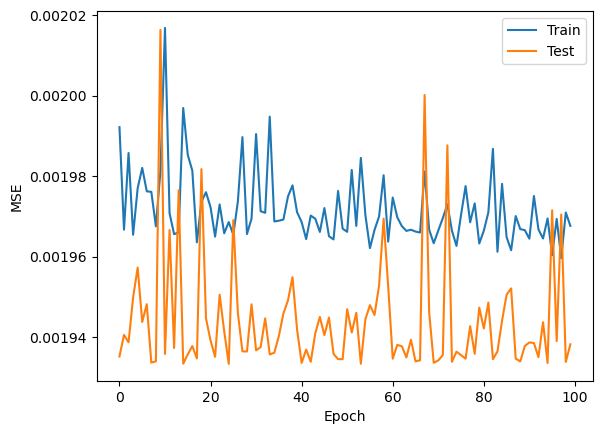

In [16]:
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [35]:
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, targets_batch in test_loader:
        inputs = inputs.to(device)
        targets_batch = targets_batch.to(device)
        outputs = model(inputs)
        
        # Assuming outputs is of shape (batch_size, sequence_length, output_dim)
        # Extract the last predictions from each sequence
        last_predictions = outputs[:, -1, :]  # This should work for any output_dim
        
        predictions.extend(last_predictions.cpu().numpy())
        targets.extend(targets_batch.cpu().numpy())

predictions = np.array(predictions)
targets = np.array(targets)

mse = np.mean((predictions - targets) ** 2)
mae = np.mean(np.abs(predictions - targets))
ssr = np.sum((targets - predictions) ** 2)
sst = np.sum((targets - np.mean(targets)) ** 2)
r2 = 1 - (ssr / sst)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)


IndexError: too many indices for tensor of dimension 2